In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [3]:
accu_df = pd.read_csv("Datasets\synthetic_accural_data.csv")
redm_df = pd.read_csv("Datasets\synthetic_redeem_data.csv")

In [4]:
accu_df.head()

,transaction_id,customer_unique_id,transaction_date,transaction_type,points,partner_id,store_id,opening_balance,closing_balance,amount,is_anomaly,anomaly_types,country_code,activity_id,category_code,sku_category_code,item_code,quantity,created_at,updated_at,bill_date,business_date,rule_id,rule_type,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,funding_partner_id,point_type_id,calculated_amount
0,TXN00002862,0006417714fe4a78913920f39a03cdf7,2023-01-06 07:30:00.000000,earn,333.09,439,3896,0.00,333.09,2307.33,0,NaN,971,186,ELEC,SKU-A1,ITM6791,6,2023-01-05 07:30:00.000000,2023-01-08 07:30:00.000000,2023-01-04 07:30:00.000000,2023-01-04 07:30:00.000000,10,base,CASH,3,65,USD,USD,USD,0.6737,1554.45,0.0805,185.74,CPN,2023-06-05 07:30:00.000000,439,9,2217.93
1,TXN00002863,0006417714fe4a78913920f39a03cdf7,2023-01-08 06:19:00.000000,earn,314.54,439,3025,333.09,647.63,4863.34,0,NaN,91,232,ELEC,SKU-C3,ITM5485,7,2023-01-07 06:19:00.000000,2023-01-08 06:19:00.000000,2023-01-07 06:19:00.000000,2023-01-05 06:19:00.000000,43,base,CASH,18,91,INR,USD,INR,0.9181,4465.03,0.0969,471.26,CPN,2024-11-02 06:19:00.000000,439,13,4883.89
2,TXN00002864,0006417714fe4a78913920f39a03cdf7,2023-01-09 10:06:00.000000,earn,341.69,212,4950,647.63,989.32,644.58,0,NaN,65,429,HM45,SKU-B2,ITM5940,9,2023-01-06 10:06:00.000000,2023-01-10 10:06:00.000000,2023-01-07 10:06:00.000000,2023-01-06 10:06:00.000000,3,base,CARD,25,65,SGD,USD,SGD,0.6280,404.80,0.0687,44.28,POS,2023-12-29 10:06:00.000000,212,19,604.63
3,TXN00002866,0006417714fe4a78913920f39a03cdf7,2023-01-11 08:48:00.000000,earn,274.21,439,1144,660.26,934.47,3202.35,0,NaN,91,297,ELEC,SKU-B2,ITM5806,4,2023-01-08 08:48:00.000000,2023-01-13 08:48:00.000000,2023-01-08 08:48:00.000000,2023-01-08 08:48:00.000000,41,base,WALLET,13,971,AED,USD,AED,1.1400,3650.68,0.0767,245.62,POS,2024-10-30 08:48:00.000000,439,15,3627.60
4,TXN00002868,0006417714fe4a78913920f39a03cdf7,2023-01-13 08:15:00.000000,earn,350.79,439,1145,885.07,1235.86,4056.82,0,NaN,91,314,FASHX,SKU-A1,ITM2370,6,2023-01-11 08:15:00.000000,2023-01-13 08:15:00.000000,2023-01-10 08:15:00.000000,2023-01-10 08:15:00.000000,32,base,CARD,1,65,AED,USD,AED,1.2190,4945.26,0.0618,250.71,CPN,2023-12-27 08:15:00.000000,439,3,4557.73


In [5]:
redm_df.head()

,transaction_id,customer_unique_id,transaction_date,transaction_type,points,partner_id,store_id,opening_balance,closing_balance,amount,is_anomaly,anomaly_types,country_code,activity_id,category_code,sku_category_code,item_code,quantity,created_at,updated_at,bill_date,business_date,rule_id,rule_type,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,funding_partner_id,point_type_id,calculated_amount
0,TXN00002865,0006417714fe4a78913920f39a03cdf7,2023-01-10 06:39:00.000000,redeem,329.06,439,4201,989.32,660.26,2309.53,0,NaN,1,175,HM45,SKU-A1,ITM7103,8,2023-01-09 06:39:00.000000,2023-01-12 06:39:00.000000,2023-01-07 06:39:00.000000,2023-01-07 06:39:00.000000,36,base,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,439,18,2016.54
1,TXN00002867,0006417714fe4a78913920f39a03cdf7,2023-01-12 11:57:00.000000,redeem,49.40,439,3571,934.47,885.07,2484.20,0,NaN,1,356,HM45,SKU-B2,ITM7192,1,2023-01-10 11:57:00.000000,2023-01-13 11:57:00.000000,2023-01-10 11:57:00.000000,2023-01-11 11:57:00.000000,33,promo,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,439,7,2087.11
2,TXN00005307,002cc23bffa546f1b6135d696f7ee2f8,2023-01-09 19:05:00.000000,redeem,312.96,435,2112,459.79,146.83,1893.40,0,NaN,1,490,GROC123,SKU-C3,ITM7112,5,2023-01-07 19:05:00.000000,2023-01-09 19:05:00.000000,2023-01-06 19:05:00.000000,2023-01-08 19:05:00.000000,33,promo,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,435,7,1596.01
3,TXN00005310,002cc23bffa546f1b6135d696f7ee2f8,2023-01-13 21:39:00.000000,redeem,37.73,435,2473,740.86,703.13,4298.60,0,NaN,971,285,FASHX,SKU-A1,ITM3385,5,2023-01-12 21:39:00.000000,2023-01-13 21:39:00.000000,2023-01-12 21:39:00.000000,2023-01-10 21:39:00.000000,49,promo,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,435,1,4166.84
4,TXN00005311,002cc23bffa546f1b6135d696f7ee2f8,2023-01-15 19:38:00.000000,redeem,87.01,435,1948,703.13,616.12,4442.77,0,NaN,65,105,GROC123,SKU-A1,ITM5996,6,2023-01-13 19:38:00.000000,2023-01-15 19:38:00.000000,2023-01-13 19:38:00.000000,2023-01-12 19:38:00.000000,39,base,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,435,14,3787.68


In [6]:
accu_df.dtypes

transaction_id                  str
customer_unique_id              str
transaction_date                str
transaction_type                str
points                      float64
partner_id                    int64
store_id                      int64
opening_balance             float64
closing_balance             float64
amount                      float64
is_anomaly                    int64
anomaly_types                   str
country_code                  int64
activity_id                   int64
category_code                   str
sku_category_code               str
item_code                       str
quantity                      int64
created_at                      str
updated_at                      str
bill_date                       str
business_date                   str
rule_id                       int64
rule_type                       str
payment_type                    str
program_id                    int64
program_country               int64
program_currency            

In [7]:
redm_df.dtypes

transaction_id                  str
customer_unique_id              str
transaction_date                str
transaction_type                str
points                      float64
partner_id                    int64
store_id                      int64
opening_balance             float64
closing_balance             float64
amount                      float64
is_anomaly                    int64
anomaly_types                   str
country_code                  int64
activity_id                   int64
category_code                   str
sku_category_code               str
item_code                       str
quantity                      int64
created_at                      str
updated_at                      str
bill_date                       str
business_date                   str
rule_id                       int64
rule_type                       str
payment_type                    str
program_id                    int64
program_country               int64
program_currency            

In [8]:
# Columns to drop
columns_to_drop = [
    'transaction_id',
    'customer_unique_id',
    'anomaly_types',
    'created_at',
    'updated_at',
    'bill_date',
    'business_date',
    'rule_id',
    'rule_type',
    'item_code',
    'sku_category_code',
    'category_code',
    'store_id',
    'activity_id',
    'funding_partner_id'
]

# Drop columns from accrual dataframe
print("Accrual DataFrame - Before drop:")
print(f"Shape: {accu_df.shape}")
print(f"Columns: {list(accu_df.columns)}")

accu_df = redm_df.drop(columns=columns_to_drop, errors='ignore')

print("\nAccrual DataFrame - After drop:")
print(f"Shape: {redm_df.shape}")
print(f"Columns: {list(accu_df.columns)}")

# Drop columns from redeem dataframe
print("\n" + "=" * 80)
print("Redeem DataFrame - Before drop:")
print(f"Shape: {redm_df.shape}")
print(f"Columns: {list(redm_df.columns)}")

redm_df = redm_df.drop(columns=columns_to_drop, errors='ignore')

print("\nRedeem DataFrame - After drop:")
print(f"Shape: {redm_df.shape}")
print(f"Columns: {list(redm_df.columns)}")

Accrual DataFrame - Before drop:
Shape: (8219, 39)
Columns: ['transaction_id', 'customer_unique_id', 'transaction_date', 'transaction_type', 'points', 'partner_id', 'store_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'anomaly_types', 'country_code', 'activity_id', 'category_code', 'sku_category_code', 'item_code', 'quantity', 'created_at', 'updated_at', 'bill_date', 'business_date', 'rule_id', 'rule_type', 'payment_type', 'program_id', 'program_country', 'program_currency', 'base_currency', 'trans_currency', 'conversion_rate', 'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd', 'channel_code', 'point_expiry', 'funding_partner_id', 'point_type_id', 'calculated_amount']

Accrual DataFrame - After drop:
Shape: (8219, 24)
Columns: ['transaction_date', 'transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency', '

In [9]:
# Convert transaction_date to datetime and extract features
print("=" * 80)
print("ACCRUAL - Processing transaction_date")
print("=" * 80)
print(f"Before: {accu_df.shape}")
print(f"Columns with 'date' in name: {[col for col in accu_df.columns if 'date' in col.lower()]}")

# Convert to datetime
accu_df['transaction_date'] = pd.to_datetime(accu_df['transaction_date'])

# Extract features
accu_df['hour'] = accu_df['transaction_date'].dt.hour
accu_df['day_of_week'] = accu_df['transaction_date'].dt.dayofweek  # 0=Monday, 6=Sunday
accu_df['is_weekend'] = (accu_df['day_of_week'].isin([5, 6])).astype(int)

# Drop original column
accu_df = accu_df.drop(columns=['transaction_date'])

print(f"After: {accu_df.shape}")
print(f"New columns added: hour, day_of_week, is_weekend")
print(f"Columns: {list(accu_df.columns)}")

print("\n" + "=" * 80)
print("REDEEM - Processing transaction_date")
print("=" * 80)
print(f"Before: {redm_df.shape}")
print(f"Columns with 'date' in name: {[col for col in redm_df.columns if 'date' in col.lower()]}")

# Convert to datetime
redm_df['transaction_date'] = pd.to_datetime(redm_df['transaction_date'])

# Extract features
redm_df['hour'] = redm_df['transaction_date'].dt.hour
redm_df['day_of_week'] = redm_df['transaction_date'].dt.dayofweek  # 0=Monday, 6=Sunday
redm_df['is_weekend'] = (redm_df['day_of_week'].isin([5, 6])).astype(int)

# Drop original column
redm_df = redm_df.drop(columns=['transaction_date'])

print(f"After: {redm_df.shape}")
print(f"New columns added: hour, day_of_week, is_weekend")
print(f"Columns: {list(redm_df.columns)}")

print("\n" + "=" * 80)
print("Sample Data")
print("=" * 80)
print("Accrual:")
print(accu_df.head())
print("\nRedeem:")
print(redm_df.head())

ACCRUAL - Processing transaction_date
Before: (8219, 24)
Columns with 'date' in name: ['transaction_date']
After: (8219, 26)
New columns added: hour, day_of_week, is_weekend
Columns: ['transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency', 'base_currency', 'trans_currency', 'conversion_rate', 'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd', 'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount', 'hour', 'day_of_week', 'is_weekend']

REDEEM - Processing transaction_date
Before: (2364, 24)
Columns with 'date' in name: ['transaction_date']
After: (2364, 26)
New columns added: hour, day_of_week, is_weekend
Columns: ['transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency

In [11]:
redm_df.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,is_anomaly,country_code,quantity,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hour,day_of_week,is_weekend
0,redeem,329.06,439,989.32,660.26,2309.53,0,1,8,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,18,2016.54,6,1,0
1,redeem,49.40,439,934.47,885.07,2484.20,0,1,1,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,7,2087.11,11,3,0
2,redeem,312.96,435,459.79,146.83,1893.40,0,1,5,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,7,1596.01,19,0,0
3,redeem,37.73,435,740.86,703.13,4298.60,0,971,5,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,1,4166.84,21,4,0
4,redeem,87.01,435,703.13,616.12,4442.77,0,65,6,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,14,3787.68,19,6,1


In [12]:
accu_y = accu_df["is_anomaly"]
redm_y = redm_df["is_anomaly"]

In [14]:
accu_X = accu_df.drop(columns=["is_anomaly"])
redm_X = redm_df.drop(columns=["is_anomaly"])

In [16]:
redm_X.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,country_code,quantity,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hour,day_of_week,is_weekend
0,redeem,329.06,439,989.32,660.26,2309.53,1,8,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,18,2016.54,6,1,0
1,redeem,49.40,439,934.47,885.07,2484.20,1,1,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,7,2087.11,11,3,0
2,redeem,312.96,435,459.79,146.83,1893.40,1,5,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,7,1596.01,19,0,0
3,redeem,37.73,435,740.86,703.13,4298.60,971,5,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,1,4166.84,21,4,0
4,redeem,87.01,435,703.13,616.12,4442.77,65,6,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,14,3787.68,19,6,1


In [24]:
cal_cols_accu = accu_X.select_dtypes(include=['str','object']).columns
cal_cols_redm = redm_X.select_dtypes(include=['str','object']).columns

print(f'accu_cat_columns {cal_cols_accu}')
print(f'redm_cat_columns {cal_cols_redm}')


accu_cat_columns Index(['transaction_type', 'payment_type', 'program_currency', 'base_currency',
       'trans_currency', 'channel_code', 'point_expiry'],
      dtype='str')
redm_cat_columns Index(['transaction_type', 'payment_type', 'program_currency', 'base_currency',
       'trans_currency', 'channel_code', 'point_expiry'],
      dtype='str')


In [19]:
# check class imbalance
print(sum(accu_y)/len(accu_y))
print(sum(redm_y)/len(redm_y))

0.19199415987346394
0.30752961082910324


In [20]:
accu_neg = (accu_y == 0).sum()
accu_pos = (accu_y == 1).sum()
accu_scale_weight = accu_neg / accu_pos

redm_neg = (redm_y == 0).sum()
redm_pos = (redm_y == 1).sum()
redm_scale_weight = redm_neg / redm_pos

In [22]:
accu_X_train, accu_X_test, accu_y_train, accu_y_test = train_test_split(accu_X, accu_y, test_size=0.2, stratify=accu_y, random_state=42)
redm_X_train, redm_X_test, redm_y_train, redm_y_test = train_test_split(redm_X, redm_y, test_size=0.2, stratify=redm_y, random_state=42)

In [65]:
accu_model = CatBoostClassifier(
    class_weights=[1, accu_scale_weight]
)

redm_model = CatBoostClassifier(
    class_weights=[1, redm_scale_weight]
)

In [66]:
accu_model.fit(accu_X_train, accu_y_train, cat_features=cal_cols_accu.tolist())

Learning rate set to 0.023024
0:	learn: 0.6784318	total: 36.6ms	remaining: 36.6s
1:	learn: 0.6649703	total: 71.9ms	remaining: 35.9s
2:	learn: 0.6555836	total: 97.7ms	remaining: 32.5s
3:	learn: 0.6440287	total: 133ms	remaining: 33.2s
4:	learn: 0.6363155	total: 155ms	remaining: 30.9s
5:	learn: 0.6299533	total: 180ms	remaining: 29.8s
6:	learn: 0.6213781	total: 225ms	remaining: 31.9s
7:	learn: 0.6148006	total: 261ms	remaining: 32.3s
8:	learn: 0.6065760	total: 298ms	remaining: 32.8s
9:	learn: 0.5973145	total: 331ms	remaining: 32.8s
10:	learn: 0.5879474	total: 368ms	remaining: 33s
11:	learn: 0.5773150	total: 402ms	remaining: 33.1s
12:	learn: 0.5702497	total: 435ms	remaining: 33.1s
13:	learn: 0.5636127	total: 475ms	remaining: 33.4s
14:	learn: 0.5565497	total: 516ms	remaining: 33.9s
15:	learn: 0.5507607	total: 556ms	remaining: 34.2s
16:	learn: 0.5452450	total: 595ms	remaining: 34.4s
17:	learn: 0.5362039	total: 635ms	remaining: 34.7s
18:	learn: 0.5302507	total: 680ms	remaining: 35.1s
19:	learn:

In [67]:
redm_model.fit(redm_X_train, redm_y_train, cat_features=cal_cols_redm.tolist())

Learning rate set to 0.013523
0:	learn: 0.6881006	total: 42.8ms	remaining: 42.7s
1:	learn: 0.6839128	total: 93.5ms	remaining: 46.6s
2:	learn: 0.6803396	total: 148ms	remaining: 49.2s
3:	learn: 0.6774051	total: 191ms	remaining: 47.5s
4:	learn: 0.6743746	total: 227ms	remaining: 45.2s
5:	learn: 0.6695842	total: 262ms	remaining: 43.4s
6:	learn: 0.6650225	total: 295ms	remaining: 41.8s
7:	learn: 0.6616180	total: 326ms	remaining: 40.5s
8:	learn: 0.6591421	total: 350ms	remaining: 38.5s
9:	learn: 0.6561317	total: 384ms	remaining: 38s
10:	learn: 0.6542314	total: 418ms	remaining: 37.6s
11:	learn: 0.6510971	total: 452ms	remaining: 37.2s
12:	learn: 0.6484669	total: 484ms	remaining: 36.7s
13:	learn: 0.6451190	total: 510ms	remaining: 35.9s
14:	learn: 0.6420685	total: 543ms	remaining: 35.6s
15:	learn: 0.6390515	total: 574ms	remaining: 35.3s
16:	learn: 0.6361542	total: 599ms	remaining: 34.6s
17:	learn: 0.6336613	total: 632ms	remaining: 34.5s
18:	learn: 0.6312472	total: 660ms	remaining: 34.1s
19:	learn: 

In [68]:
accu_y_pred = accu_model.predict(accu_X_test)
redm_y_pred = redm_model.predict(redm_X_test)

print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

accuracy for accu_model: 0.8838199513381995
accuracy for redm_model: 0.7441860465116279


In [69]:
print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      1328
           1       0.67      0.77      0.72       316

    accuracy                           0.88      1644
   macro avg       0.81      0.84      0.82      1644
weighted avg       0.89      0.88      0.89      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       328
           1       0.58      0.59      0.59       145

    accuracy                           0.74       473
   macro avg       0.70      0.70      0.70       473
weighted avg       0.75      0.74      0.74       473



accu_model confusion matrix:-

redm_model confusion matrix:-



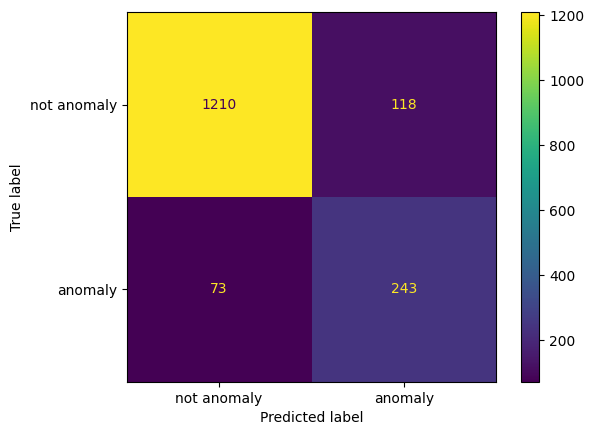

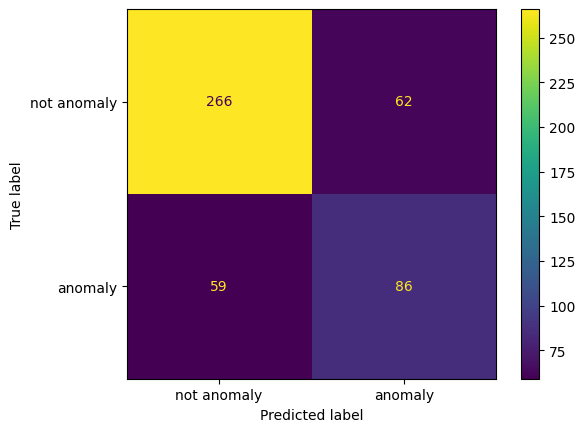

In [70]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

In [72]:
import os

# Create output directory if it doesn't exist
output_dir = 'model_predictions'
os.makedirs(output_dir, exist_ok=True)

# ============ ACCRUAL MODEL ============
print("=" * 80)
print("EXPORTING ACCRUAL MODEL PREDICTIONS AND CLASSIFICATION REPORT")
print("=" * 80)

# Create dataframe with actual vs predicted values
accu_comparison = pd.DataFrame({
    'actual': accu_y_test.values,
    'predicted': accu_y_pred,
    'match': (accu_y_test.values == accu_y_pred).astype(int)
})

# Export predictions to CSV
accu_pred_file = os.path.join(output_dir, 'accu_predictions.csv')
accu_comparison.to_csv(accu_pred_file, index=False)
print(f"✓ Predictions exported to: {accu_pred_file}")
print(f"  Shape: {accu_comparison.shape}")
print(f"  Preview:\n{accu_comparison.head()}")

# Generate classification report
from sklearn.metrics import classification_report
accu_class_report = classification_report(accu_y_test, accu_y_pred, output_dict=True)
accu_report_df = pd.DataFrame(accu_class_report).transpose()

# Export classification report to CSV
accu_report_file = os.path.join(output_dir, 'accu_classification_report.csv')
accu_report_df.to_csv(accu_report_file)
print(f"\n✓ Classification Report exported to: {accu_report_file}")
print(f"  {accu_report_file}:\n{accu_report_df}")

# ============ REDEEM MODEL ============
print("\n" + "=" * 80)
print("EXPORTING REDEEM MODEL PREDICTIONS AND CLASSIFICATION REPORT")
print("=" * 80)

# Create dataframe with actual vs predicted values
redm_comparison = pd.DataFrame({
    'actual': redm_y_test.values,
    'predicted': redm_y_pred,
    'match': (redm_y_test.values == redm_y_pred).astype(int)
})

# Export predictions to CSV
redm_pred_file = os.path.join(output_dir, 'redm_predictions.csv')
redm_comparison.to_csv(redm_pred_file, index=False)
print(f"✓ Predictions exported to: {redm_pred_file}")
print(f"  Shape: {redm_comparison.shape}")
print(f"  Preview:\n{redm_comparison.head()}")

# Generate classification report
redm_class_report = classification_report(redm_y_test, redm_y_pred, output_dict=True)
redm_report_df = pd.DataFrame(redm_class_report).transpose()

# Export classification report to CSV
redm_report_file = os.path.join(output_dir, 'redm_classification_report.csv')
redm_report_df.to_csv(redm_report_file)
print(f"\n✓ Classification Report exported to: {redm_report_file}")
print(f"\n{redm_report_file}:\n{redm_report_df}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Files created in '{output_dir}/' directory:")
print(f"  1. accu_predictions.csv - {len(accu_comparison)} predictions")
print(f"  2. accu_classification_report.csv")
print(f"  3. redm_predictions.csv - {len(redm_comparison)} predictions")
print(f"  4. redm_classification_report.csv")

EXPORTING ACCRUAL MODEL PREDICTIONS AND CLASSIFICATION REPORT
✓ Predictions exported to: model_predictions\accu_predictions.csv
  Shape: (1644, 3)
  Preview:
   actual  predicted  match
0       0          1      0
1       1          1      1
2       1          0      0
3       0          0      1
4       0          0      1

✓ Classification Report exported to: model_predictions\accu_classification_report.csv
  model_predictions\accu_classification_report.csv:
              precision    recall  f1-score     support
0              0.943102  0.911145  0.926848  1328.00000
1              0.673130  0.768987  0.717873   316.00000
accuracy       0.883820  0.883820  0.883820     0.88382
macro avg      0.808116  0.840066  0.822360  1644.00000
weighted avg   0.891210  0.883820  0.886680  1644.00000

EXPORTING REDEEM MODEL PREDICTIONS AND CLASSIFICATION REPORT
✓ Predictions exported to: model_predictions\redm_predictions.csv
  Shape: (473, 3)
  Preview:
   actual  predicted  match
0       1     

In [38]:
param_grid = {
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "iterations": [300, 500, 700, 1000],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "border_count": [32, 64, 128],
    "bagging_temperature": [0, 0.5, 1, 3, 5],
    "random_strength": [0.5, 1, 2, 5]
}

In [42]:
# accu_random_search = RandomizedSearchCV(
#     estimator=CatBoostClassifier(
#     eval_metric="AUC",
#     loss_function="Logloss",
#     verbose=0,
#     class_weights=[1, accu_scale_weight]
# ),
#     param_distributions=param_grid,
#     n_iter=30,
#     scoring="average_precision",
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=1
# )

In [51]:
train_pool = Pool(
    data=accu_X_train,
    label=accu_y_train,
    cat_features=cal_cols_accu.tolist()
)

model = CatBoostClassifier(
    eval_metric="AUC",
    loss_function="Logloss",
    verbose=0,
    class_weights=[1, accu_scale_weight]
)
accu_model = model.randomized_search(param_grid, X=train_pool, cv=3, n_iter=30, stratified=True, verbose=False)


bestTest = 0.9277220697
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8992488371
bestIteration = 289

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9267472781
bestIteration = 259

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.92007784
bestIteration = 434

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9277507401
bestIteration = 220

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9018112488
bestIteration = 685

Metric AUC is not calculated on train by default. To calc

In [54]:
accu_best_params = accu_model['params']
print(accu_best_params)

{'border_count': 128, 'bagging_temperature': 0, 'random_strength': 0.5, 'depth': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 1000}


In [53]:
train_pool_2 = Pool(
    data=redm_X_train,
    label=redm_y_train,
    cat_features=cal_cols_redm.tolist()
)

model_2 = CatBoostClassifier(
    eval_metric="AUC",
    loss_function="Logloss",
    verbose=0,
    thread_count=-1,
    class_weights=[1, redm_scale_weight]
)

redm_model = model_2.randomized_search(param_grid, X=train_pool_2, cv=3, n_iter=30, stratified=True, verbose=False)


bestTest = 0.8268015171
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7828198816
bestIteration = 297

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8203473285
bestIteration = 166

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8261028678
bestIteration = 471

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8211457848
bestIteration = 156

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7993878502
bestIteration = 697

Metric AUC is not calculated on train by default. To ca

In [55]:
redm_best_params = redm_model['params']
print(redm_best_params)

{'border_count': 128, 'bagging_temperature': 5, 'random_strength': 5, 'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300}


In [58]:
accu_best_model = CatBoostClassifier(**accu_best_params, verbose=0)
accu_best_model.fit(accu_X_train, accu_y_train, cat_features=cal_cols_accu.tolist())

In [59]:
redm_best_model = CatBoostClassifier(**redm_best_params)
redm_best_model.fit(redm_X_train, redm_y_train, cat_features=cal_cols_redm.tolist())

0:	learn: 0.6782760	total: 13.6ms	remaining: 4.07s
1:	learn: 0.6611413	total: 27.3ms	remaining: 4.07s
2:	learn: 0.6516503	total: 45.3ms	remaining: 4.48s
3:	learn: 0.6440429	total: 47.1ms	remaining: 3.48s
4:	learn: 0.6284458	total: 68.2ms	remaining: 4.03s
5:	learn: 0.6234092	total: 89.8ms	remaining: 4.4s
6:	learn: 0.6194247	total: 95.3ms	remaining: 3.99s
7:	learn: 0.6162151	total: 101ms	remaining: 3.67s
8:	learn: 0.6090979	total: 121ms	remaining: 3.91s
9:	learn: 0.6012875	total: 142ms	remaining: 4.13s
10:	learn: 0.5989713	total: 164ms	remaining: 4.3s
11:	learn: 0.5974334	total: 184ms	remaining: 4.42s
12:	learn: 0.5916070	total: 206ms	remaining: 4.55s
13:	learn: 0.5774777	total: 227ms	remaining: 4.64s
14:	learn: 0.5730829	total: 250ms	remaining: 4.76s
15:	learn: 0.5689160	total: 274ms	remaining: 4.87s
16:	learn: 0.5664425	total: 287ms	remaining: 4.77s
17:	learn: 0.5626873	total: 308ms	remaining: 4.82s
18:	learn: 0.5589344	total: 327ms	remaining: 4.84s
19:	learn: 0.5513955	total: 347ms	re

In [60]:
accu_y_pred = accu_best_model.predict(accu_X_test)
redm_y_pred = redm_best_model.predict(redm_X_test)

print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

accuracy for accu_model: 0.9093673965936739
accuracy for redm_model: 0.7758985200845666


In [61]:
print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1328
           1       0.87      0.62      0.73       316

    accuracy                           0.91      1644
   macro avg       0.89      0.80      0.84      1644
weighted avg       0.91      0.91      0.90      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       328
           1       0.72      0.43      0.54       145

    accuracy                           0.78       473
   macro avg       0.76      0.68      0.70       473
weighted avg       0.77      0.78      0.76       473



accu_model confusion matrix:-

redm_model confusion matrix:-



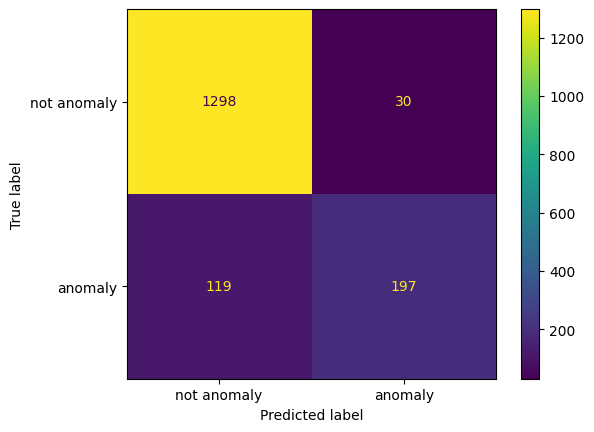

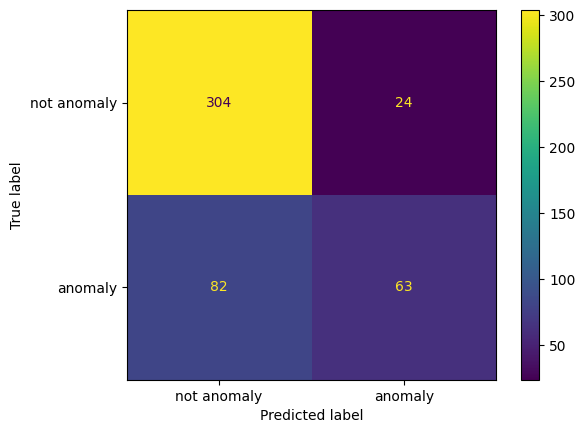

In [62]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

In [64]:
from sklearn.metrics import classification_report
import os

# Create output directory if it doesn't exist
output_dir = 'model_predictions'
os.makedirs(output_dir, exist_ok=True)

# ============ ACCRUAL MODEL ============
print("=" * 80)
print("EXPORTING ACCRUAL MODEL PREDICTIONS AND CLASSIFICATION REPORT")
print("=" * 80)

# Create dataframe with actual vs predicted values
accu_comparison = pd.DataFrame({
    'actual': accu_y_test.values,
    'predicted': accu_y_pred,
    'match': (accu_y_test.values == accu_y_pred).astype(int)
})

# Export predictions to CSV
accu_pred_file = os.path.join(output_dir, 'accu_predictions.csv')
accu_comparison.to_csv(accu_pred_file, index=False)
print(f"✓ Predictions exported to: {accu_pred_file}")
print(f"  Shape: {accu_comparison.shape}")
print(f"  Preview:\n{accu_comparison.head()}")

# Generate classification report
from sklearn.metrics import classification_report
accu_class_report = classification_report(accu_y_test, accu_y_pred, output_dict=True)
accu_report_df = pd.DataFrame(accu_class_report).transpose()

# Export classification report to CSV
accu_report_file = os.path.join(output_dir, 'accu_classification_report.csv')
accu_report_df.to_csv(accu_report_file)
print(f"\n✓ Classification Report exported to: {accu_report_file}")
print(f"  {accu_report_file}:\n{accu_report_df}")

# ============ REDEEM MODEL ============
print("\n" + "=" * 80)
print("EXPORTING REDEEM MODEL PREDICTIONS AND CLASSIFICATION REPORT")
print("=" * 80)

# Create dataframe with actual vs predicted values
redm_comparison = pd.DataFrame({
    'actual': redm_y_test.values,
    'predicted': redm_y_pred,
    'match': (redm_y_test.values == redm_y_pred).astype(int)
})

# Export predictions to CSV
redm_pred_file = os.path.join(output_dir, 'redm_predictions.csv')
redm_comparison.to_csv(redm_pred_file, index=False)
print(f"✓ Predictions exported to: {redm_pred_file}")
print(f"  Shape: {redm_comparison.shape}")
print(f"  Preview:\n{redm_comparison.head()}")

# Generate classification report
redm_class_report = classification_report(redm_y_test, redm_y_pred, output_dict=True)
redm_report_df = pd.DataFrame(redm_class_report).transpose()

# Export classification report to CSV
redm_report_file = os.path.join(output_dir, 'redm_classification_report.csv')
redm_report_df.to_csv(redm_report_file)
print(f"\n✓ Classification Report exported to: {redm_report_file}")
print(f"\n{redm_report_file}:\n{redm_report_df}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Files created in '{output_dir}/' directory:")
print(f"  1. accu_predictions.csv - {len(accu_comparison)} predictions")
print(f"  2. accu_classification_report.csv")
print(f"  3. redm_predictions.csv - {len(redm_comparison)} predictions")
print(f"  4. redm_classification_report.csv")

EXPORTING ACCRUAL MODEL PREDICTIONS AND CLASSIFICATION REPORT
✓ Predictions exported to: model_predictions\accu_predictions.csv
  Shape: (1644, 3)
  Preview:
   actual  predicted  match
0       0          1      0
1       1          0      0
2       1          0      0
3       0          0      1
4       0          0      1

✓ Classification Report exported to: model_predictions\accu_classification_report.csv
  model_predictions\accu_classification_report.csv:
              precision    recall  f1-score      support
0              0.916020  0.977410  0.945719  1328.000000
1              0.867841  0.623418  0.725599   316.000000
accuracy       0.909367  0.909367  0.909367     0.909367
macro avg      0.891931  0.800414  0.835659  1644.000000
weighted avg   0.906759  0.909367  0.903409  1644.000000

EXPORTING REDEEM MODEL PREDICTIONS AND CLASSIFICATION REPORT
✓ Predictions exported to: model_predictions\redm_predictions.csv
  Shape: (473, 3)
  Preview:
   actual  predicted  match
0       